# Pre-Equilibrium Maximazation of Yield #

In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
# sys.path.append("../../../")
import copy

In [2]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy
from KineticAssembly_AD import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver, TrapMetric
import networkx as nx
import torch
from torch import DoubleTensor as Tensor

We'll start with the AP2 complex that we've worked with before. Pairwise $\Delta Gs$ were derived from the PDB structures via Rossetta

In [3]:
base_input = '../input_files/tetramer_rategrowth.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()


['default_assoc', 1.0]
['monomer_add_only', True]
['homo_rates', True]
[(0, {'struct': <networkx.classes.graph.Graph object at 0x000001F8894C8F60>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1}), (1, {'struct': <networkx.classes.graph.Graph object at 0x000001F888E155F8>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1}), (2, {'struct': <networkx.classes.graph.Graph object at 0x000001F8894AEEF0>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1}), (3, {'struct': <networkx.classes.graph.Graph object at 0x000001F8894AE4A8>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})]
New node added - Node index: 4 ; Node label: AM 
New node added - Node index: 5 ; Node label: AB 
New node added - Node index: 6 ; Node label: AS 
New node added - Node index: 7 ; Node label: BM 
New node added - Node index: 8 ; Node label: MS 
New node added - Node index: 9 ; Node label: ABM 
New node added - Node index: 10 ; Node label: AMS 
New node added - Node 

In [4]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    print(n,'--',gtostr(rn.network.nodes[n]['struct']))
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid


print(uid_dict)

0 -- A
1 -- M
2 -- B
3 -- S
4 -- AM
5 -- AB
6 -- AS
7 -- BM
8 -- MS
9 -- ABM
10 -- AMS
11 -- BS
12 -- ABS
13 -- BMS
14 -- ABMS
{(0, 4): 0, (0, 5): 1, (0, 6): 2, (0, 9): 16, (0, 10): 17, (0, 12): 18, (0, 14): 21, (1, 4): 0, (1, 7): 3, (1, 8): 4, (1, 9): 5, (1, 10): 6, (1, 13): 19, (1, 14): 20, (2, 5): 1, (2, 7): 3, (2, 11): 7, (2, 9): 8, (2, 12): 9, (2, 13): 10, (2, 14): 11, (3, 6): 2, (3, 8): 4, (3, 11): 7, (3, 10): 12, (3, 12): 13, (3, 13): 14, (3, 14): 15, (4, 9): 8, (4, 10): 12, (5, 9): 5, (5, 12): 13, (6, 10): 6, (6, 12): 9, (7, 13): 14, (7, 9): 16, (8, 13): 10, (8, 10): 17, (9, 14): 15, (10, 14): 11, (11, 12): 18, (11, 13): 19, (12, 14): 20, (13, 14): 21}


In [5]:
#Do modifications here
#Changing Initial Conditions
import networkx as nx
#Changin k_on
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()
new_kon = new_kon + Tensor([1.]*np.array(2e0))
new_kon[0]=1.0
# par_kon = [4.0506, 0.0127, 3.4233, 2.8482]
# counter=0
# for cls,uids in rn.rxn_class.items():
#     new_kon[uids]=par_kon[counter]
#     counter+=1

update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')

# for edge in rn.network.edges:
#     print(rn.network.get_edge_data(edge[0],edge[1]))
vec_rn = VectorizedRxnNet(rn, dev='cpu')
print(vec_rn.kon)

#Changing initial concentrations

{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 16}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 17}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 18}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-60.], dtype=torch.float64), 'uid': 21}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 4}
{'k_on

## Using the optimizer ##

### Define an instance of the optimizer class
#### Input Arguments:

reaction_network : Input the vectorized rxn network

sim_runtime: The runtime of the kinetic simulation. Needs to be same as the time over the experimental reaction data.

optim_iterations: No. of iterations to run the optimization. Can start at low values(100) and increase depending upon memory usage.

learning_rate = The size of the gradient descent step for updating parameter values. Needs to be atleast (1e-3-1e-1)* min{parameter value}. If learning rate is too high, it can take a longer step and sometimes lead to negative value of parameters which is unphysical. Requires some trial runs to find the best value. 

device: cpu or gpu

method: Choose which pytorch based optimized to use for gradient descent - Adam or RMSprop

mom: Only for RMSprop method. Use momentum term during gradient descent. 


In [6]:
vec_rn.reset(reset_params=True)
optim = Optimizer(reaction_network=vec_rn,
                  sim_runtime=1,
                  optim_iterations=100,
                  learning_rate=1e-2,
                  device='cpu',method="RMSprop")


### Call the optimization method

#### Input arguments

conc_scale, conc_thresh, mod_bool, mod_factor = As defined for the VecSim class. 

max_thresh: Max. allowed values of parameters being updated. Beyond this maximum a penalty is imposed on the cost function. (Regularization)

max_yield: It is a control variable that is used to store the updated parameter values over all iterations for further analysis. The parameter values are stored only if the current yield exceed this max_yield. 

yield_species: Yield of the species being optimized(node index). Default value is -1 (picks the last element from the array which is always the final complex for a fully connected topology)

In [7]:
optim.rn.update_reaction_net(rn)
optim.optimize(conc_scale=1,conc_thresh=1,max_thresh=100,max_yield=0)

Reaction Parameters before optimization: 
[Parameter containing:
tensor([1., 2., 2.], dtype=torch.float64, requires_grad=True)]
Optimizer State: <bound method Optimizer.state_dict of RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01
    momentum: 0
    weight_decay: 0
)>
Using CPU
Yield on sim. iteration 0 was 39.9%.
current params: tensor([1., 2., 2.], dtype=torch.float64)
tensor(0.4000, dtype=torch.float64, grad_fn=<DivBackward0>)
Using CPU
Yield on sim. iteration 1 was 37.5%.
current params: tensor([1.1000, 1.9000, 2.1000], dtype=torch.float64)
tensor(0.3757, dtype=torch.float64, grad_fn=<DivBackward0>)
Using CPU
Yield on sim. iteration 2 was 38.8%.
current params: tensor([1.0844, 1.8862, 2.1960], dtype=torch.float64)
tensor(0.3881, dtype=torch.float64, grad_fn=<DivBackward0>)
Using CPU
Yield on sim. iteration 3 was 41.1%.
current params: tensor([1.0334, 1.9073, 2.2735], dtype=torch.float64)
tensor(0.4112, dtype=torch.float64, grad_fn=<DivBa

## Track the yield over optim iterations

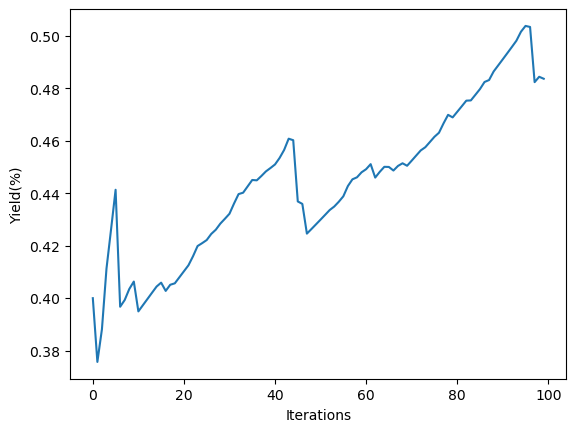

In [8]:
optim.plot_yield()

## Get all the parameter values

### This can be stored in a file for later analysis or used to find the best parameter value depending upon a condition. For e.g. the values that give a minimum error.

In [9]:
yields= []
final_params=[]

final_t50 = []
final_t85 = []
final_t95 = []
final_t99 = []

for i in range(len(optim.final_yields)):
    yields.append(optim.final_yields[i])
    final_params.append(optim.final_solns[i])
    #Storing the different time points it reaches a particular yield threshold
    if optim.final_t85[i] == -1:
        final_t85.append(1) 
    else:
        final_t85.append(optim.final_t85[i]) 
    if optim.final_t95[i] == -1:
        final_t95.append(1)
    else:
        final_t95.append(optim.final_t95[i])
        
    

final_yield_arr = np.array(yields)
final_param_arr = np.array(final_params)
final_t85 = np.array(final_t85)
final_t95 = np.array(final_t95)

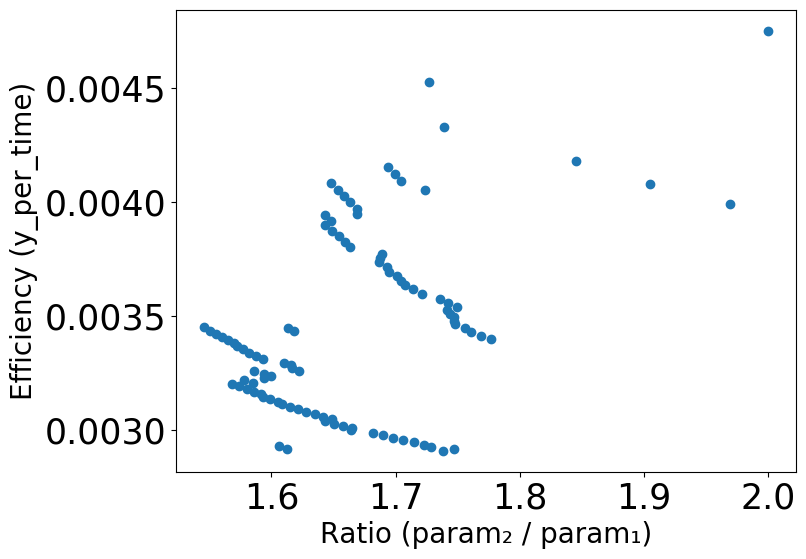

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assume final_yield_arr (1D), final_param_arr (2D, shape=(N, 3)), final_t95 (1D), and vec_rn are already defined

# 1. Create a boolean mask for yields > 0.5
mask_r = final_yield_arr > 0.1

# 2. Compute the ratio of the second to the first parameter for all runs
ratio = final_param_arr[:, 1] / final_param_arr[:, 0]

# 3. Apply the same mask to ratio so that it matches the filtered y_per_time array
ratio_masked = ratio[mask_r]

# 4. Compute the maximum “rate” in each row of final_param_arr (only for the masked rows)
max_rates_masked = np.max(final_param_arr[mask_r], axis=1)

# 5. Get the concentration (assuming vec_rn.initial_copies[0] exists)
conc = vec_rn.initial_copies[0].item()

# 6. Compute scale_time for the masked entries
#    (t = final_t95[mask_r] * conc * max_rates_masked)
scale_time = final_t95[mask_r] * conc * max_rates_masked

# 7. Calculate efficiency y_per_time = 0.95 / scale_time
y_per_time = 0.95 / scale_time

# 8. Plot ratio_masked vs. y_per_time
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(ratio_masked, y_per_time, linestyle='', marker='o')
ax.set_xlabel("Ratio (param₂ / param₁)", fontsize=20)
ax.set_ylabel("Efficiency (y_per_time)", fontsize=20)
ax.tick_params(labelsize=25)
plt.show()

In [11]:
#OLD CODE THAT DID NOT WORK
'''import matplotlib.pyplot as plt

mask_r = final_yield_arr > 0.5

#Calculate the ratio
ratio = final_param_arr[:,1]/final_param_arr[:,0]

#Normalize the time scale (t = t*conc*max_rate)
conc=vec_rn.initial_copies[0].item()
scale_time = final_t95[mask_r]*conc*np.max(final_param_arr[mask_r],axis=1)
#Calculate the y_per_time
y_per_time = 0.95/scale_time

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(ratio,y_per_time,linestyle='',marker='o')
ax.set_ylabel("Efficiency",fontsize=20)
ax.set_xlabel("Ratio",fontsize=20)
ax.tick_params(labelsize=25)''''


SyntaxError: EOL while scanning string literal (246647146.py, line 19)